In [1]:
pip install tensorflow_datasets

Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install tensorboard

In [3]:
import tensorflow as tf

In [4]:
import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix

import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

AUTOTUNE = tf.data.AUTOTUNE

In [5]:
dataset, metadata = tfds.load('cycle_gan/horse2zebra',
                              with_info=True, as_supervised=True)

train_horses, train_zebras = dataset['trainA'], dataset['trainB']
test_horses, test_zebras = dataset['testA'], dataset['testB']

# train_horses = train_horses.take(50)
# train_zebras = train_zebras.take(60)
# print(type(train_horses))
# half_train_horses = train_horses.take(400)

# half_train_zebras = train_horses.take(500)

# half_test_horses = test_horses.take(60)

# half_test_zebras = test_zebras.take(70)

print(len(train_horses))

print(len(train_zebras))
print(len(test_horses))

print(len(test_zebras))


BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

1067
1334
120
140


2022-06-03 17:11:41.515744: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
def random_crop(image):
  cropped_image = tf.image.random_crop(
      image, size=[IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image

In [7]:
# normalizing the images to [-1, 1]
def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image

In [8]:
def random_jitter(image):
  # resizing to 286 x 286 x 3
  image = tf.image.resize(image, [286, 286],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  # randomly cropping to 256 x 256 x 3
  image = random_crop(image)

  # random mirroring
  image = tf.image.random_flip_left_right(image)

  return image

In [9]:
def preprocess_image_train(image, label):
  image = random_jitter(image)
  image = normalize(image)
  return image

In [10]:
def preprocess_image_test(image, label):
  image = normalize(image)
  return image

In [11]:
train_horses = train_horses.cache().map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

train_zebras = train_zebras.cache().map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

test_horses = test_horses.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

test_zebras = test_zebras.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

In [12]:
sample_horse = next(iter(train_horses))
sample_zebra = next(iter(train_zebras))

2022-06-03 17:11:42.571509: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2022-06-03 17:11:42.571680: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2022-06-03 17:11:43.281623: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. I

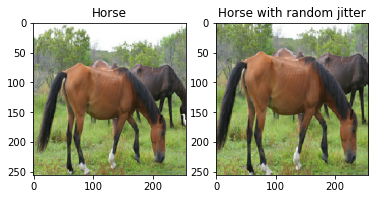

In [13]:
plt.subplot(121)
plt.title('Horse')
plt.imshow(sample_horse[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Horse with random jitter')
plt.imshow(random_jitter(sample_horse[0]) * 0.5 + 0.5)

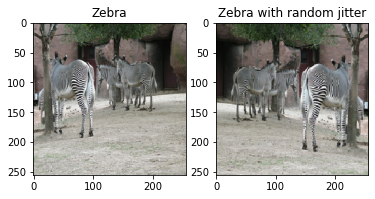

In [14]:
plt.subplot(121)
plt.title('Zebra')
plt.imshow(sample_zebra[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Zebra with random jitter')
plt.imshow(random_jitter(sample_zebra[0]) * 0.5 + 0.5)

In [15]:
OUTPUT_CHANNELS = 3

generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

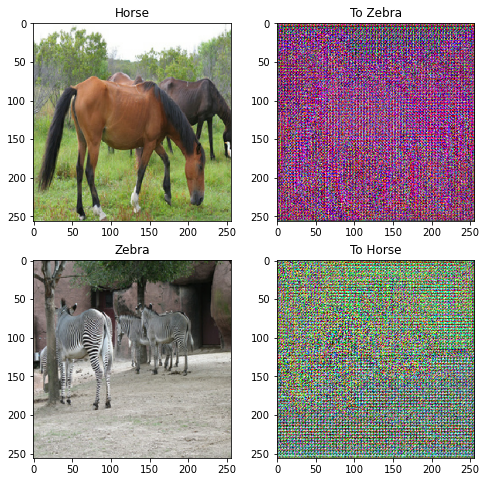

In [16]:
to_zebra = generator_g(sample_horse)
to_horse = generator_f(sample_zebra)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_horse, to_zebra, sample_zebra, to_horse]
title = ['Horse', 'To Zebra', 'Zebra', 'To Horse']

for i in range(len(imgs)):
  plt.subplot(2, 2, i+1)
  plt.title(title[i])
  if i % 2 == 0:
    plt.imshow(imgs[i][0] * 0.5 + 0.5)
  else:
    plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
plt.show()

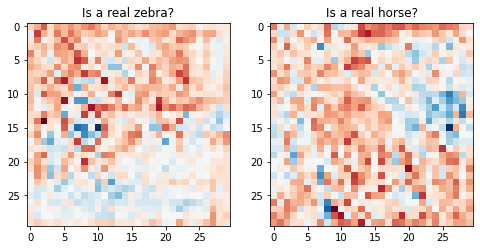

In [17]:
plt.figure(figsize=(8, 8))

plt.subplot(121)
plt.title('Is a real zebra?')
plt.imshow(discriminator_y(sample_zebra)[0, ..., -1], cmap='RdBu_r')

plt.subplot(122)
plt.title('Is a real horse?')
plt.imshow(discriminator_x(sample_horse)[0, ..., -1], cmap='RdBu_r')

plt.show()

In [18]:
LAMBDA = 10
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)


In [19]:
def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)

  generated_loss = loss_obj(tf.zeros_like(generated), generated)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss * 0.5


In [20]:
def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)


In [21]:
def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
  
  return LAMBDA * loss1

In [22]:
def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

In [23]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [24]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

Latest checkpoint restored!!


In [25]:
def generate_images(model, test_input):
  prediction = model(test_input)
    
  plt.figure(figsize=(12, 12))

  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()


In [26]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def generator_loss_pix2pix(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # Mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

In [27]:
def discriminator_loss_pix2pix(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

In [28]:
# Define the optimizers and a checkpoint-saver
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [29]:
import datetime
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "newfit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [30]:
total_gen_g_losses = []
disc_x_losses = []

In [31]:

@tf.function
def train_step_pix2pix(input_image, target):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator_g(input_image, training=True)

    disc_real_output = discriminator_x(target, training=True)
    disc_generated_output = discriminator_x(gen_output, training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss_pix2pix(disc_generated_output, gen_output, target)
    
    
    disc_loss = discriminator_loss_pix2pix(disc_real_output, disc_generated_output)
    
  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator_g.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator_x.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator_g.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator_x.trainable_variables))
  return gen_total_loss,disc_loss

In [32]:

def fit_pix2pix(epochs):
    for epoch in range(epochs):
      start = time.time()

      n = 0
      for image_x, image_y in tf.data.Dataset.zip((train_horses, train_zebras)):
        gen_total_loss,disc_loss=train_step_pix2pix(image_x, image_y)
        with summary_writer.as_default():
            tf.summary.scalar('gen_total_loss', gen_total_loss, epoch)
            #tf.summary.scalar('gen_gan_loss', gen_gan_loss, epoch)
            #tf.summary.scalar('gen_l1_loss', gen_l1_loss, epoch)
            tf.summary.scalar('disc_loss', disc_loss, epoch)  
        if n % 10 == 0:
          print ('.', end='')
        n += 1

      
      clear_output(wait=True)
      # Using a consistent image (sample_horse) so that the progress of the model
      # is clearly visible.
      generate_images(generator_g, sample_horse)

      if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                             ckpt_save_path))

      print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                          time.time()-start))

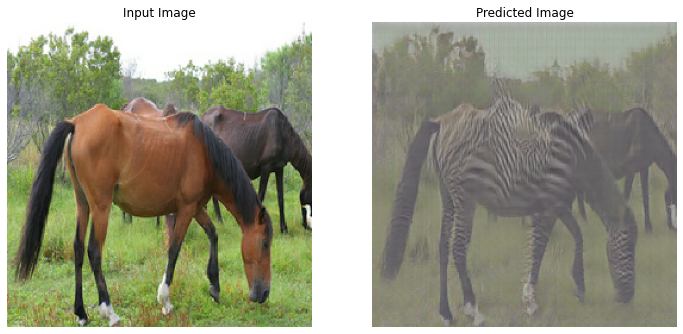

Saving checkpoint for epoch 5 at ./checkpoints/train/ckpt-40
Time taken for epoch 5 is 921.7472968101501 sec



In [33]:
EPOCHS = 5
!pip install tensorboard
%reload_ext tensorboard
%tensorboard --logdir {log_dir} --host localhost
fit_pix2pix(EPOCHS)

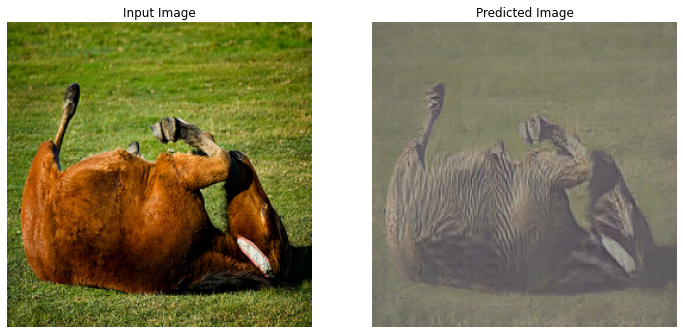

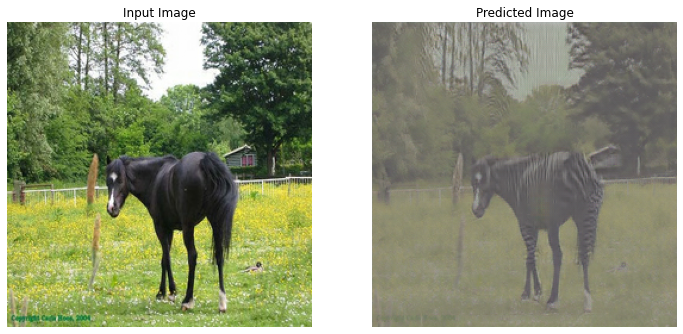

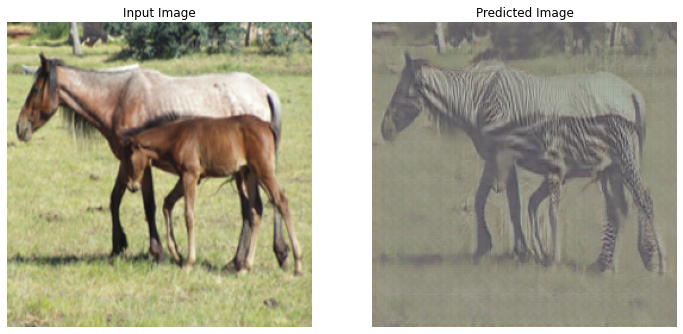

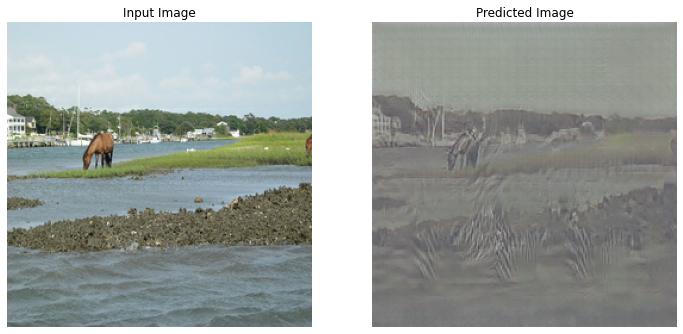

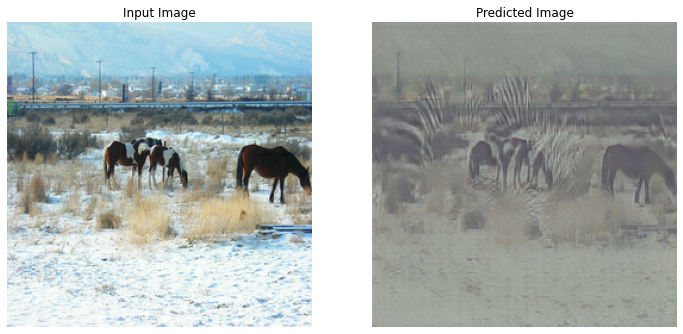

In [34]:
# Run the trained model on the test dataset
for inp in test_horses.take(5):
  generate_images(generator_g, inp)

In [35]:
gen_g_losses = []
gen_f_losses = []
total_cycle_losses =[]
total_gen_g_losses = []
total_gen_f_losses = []
disc_x_losses = []
disc_y_losses = []
@tf.function
def train_step(real_x, real_y):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
#   run_dir = "output/gradients/run-" + str(step_count)
#   with tf.summary.create_file_writer(run_dir).as_default():

  with tf.GradientTape(persistent=True) as tape:
    # Generator G translates X -> Y
    # Generator F translates Y -> X.

    fake_y = generator_g(real_x, training=True)
    cycled_x = generator_f(fake_y, training=True)

    fake_x = generator_f(real_y, training=True)
    cycled_y = generator_g(fake_x, training=True)

    # same_x and same_y are used for identity loss.
    same_x = generator_f(real_x, training=True)
    same_y = generator_g(real_y, training=True)

    disc_real_x = discriminator_x(real_x, training=True)
    disc_real_y = discriminator_y(real_y, training=True)

    disc_fake_x = discriminator_x(fake_x, training=True)
    disc_fake_y = discriminator_y(fake_y, training=True)

    # calculate the loss
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)
    gen_g_losses.append(tf.get_static_value(gen_g_loss))
    gen_f_losses.append(tf.get_static_value(gen_f_loss))

    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)
    total_cycle_losses.append(tf.get_static_value(total_cycle_loss))

    # Total generator loss = adversarial loss + cycle loss
    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)
    total_gen_g_losses.append(tf.get_static_value(total_gen_g_loss))
    total_gen_f_losses.append(tf.get_static_value(total_gen_f_loss))

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)
    disc_x_losses.append(tf.get_static_value(disc_x_loss))
    disc_y_losses.append(tf.get_static_value(disc_y_loss))

  # Calculate the gradients for generator and discriminator
  generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)

  discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)

  # Apply the gradients to the optimizer
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))

  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))

  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))
    
  return total_gen_g_loss,total_gen_f_loss, disc_x_losses, disc_y_losses

In [36]:
gen_loss =[]
genf_loss=[]
discx_loss=[]
discy_loss=[]

def fit_cycleGan(epochs):
    for epoch in range(epochs):
      start = time.time()

      n = 0
      for image_x, image_y in tf.data.Dataset.zip((train_horses, train_zebras)):
         gen_g_loss, gen_f_loss, disc_x_loss, disc_y_loss = train_step(image_x, image_y)
         with summary_writer.as_default():
            tf.summary.scalar('gen_g_loss', gen_g_loss, epoch)
            tf.summary.scalar('disc_x_loss', disc_x_loss, epoch) 
        
         if n % 10 == 0:
            print ('.', end='')
         n += 1

       
      clear_output(wait=True)
      # Using a consistent image (sample_horse) so that the progress of the model
      # is clearly visible.
      generate_images(generator_g, sample_horse)

      if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                             ckpt_save_path))
      print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                          time.time()-start))

In [37]:
EPOCHS = 10
fit_cycleGan(EPOCHS)

ValueError: Attempt to convert a value (None) with an unsupported type (<class 'NoneType'>) to a Tensor.

In [ ]:
# Run the trained model on the test dataset
for inp in test_horses.take(5):
  generate_images(generator_g, inp)

In [ ]:


display.IFrame(
    src="https://tensorboard.dev/experiment/lZ0C6FONROaUMfjYkVyJqw",
    width="100%",
    height="1000px")

In [ ]:
import matplotlib.pyplot as plt

def plot_error(error_arr, ylabel):
    plt.xlabel('k')
    plt.ylabel(ylabel)
    plt.plot(error_arr)  # plotting by columns
    path = ylabel + '.jpg'
    plt.savefig(path)
    plt.show()

In [ ]:

# print(gen_g_losses.reduction('AUTO'))
print(gen_loss)
print(genf_loss)
print(discx_loss)
print(discy_loss)
plot_error(gen_loss, 'gen_g_loss')
plot_error(genf_loss, 'gen_f_loss')
plot_error(discx_loss, 'disc_x_loss')
plot_error(discy_loss, 'disc_y_loss')

In [ ]:
# print(total_gen_g_loss)